In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from Optimization.PreparedData import X_train, X_valid, y_train, y_valid, X_test
from sklearn.metrics import roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
from matplotlib.gridspec import GridSpec
from xgboost import XGBClassifier

In [2]:
df1 = pd.read_csv('metrics/gbtree/CMA/metrics_2026-01-20 08:27:12.393529.csv')

current_time = datetime.now()

In [3]:
time = np.arange(0, df1.shape[0], 1)

acc = df1['accuracy']
prec = df1['precision']
rec = df1['recall']
f1 = df1['f1']
lr = df1['learning curve']
gini = df1['gini']

metrics_cma = [('Accuracy', acc),
           ('Precision', prec),
           ('Recall', rec),
           ('F1', f1),
           ('Learning Curve', lr),
           ('Normalized Gini Coeff', gini),]

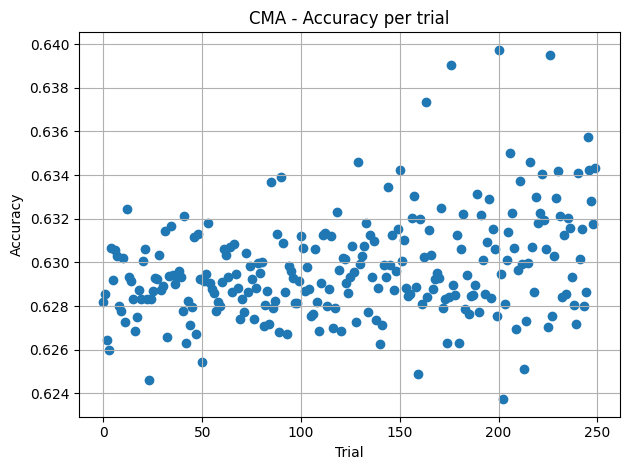

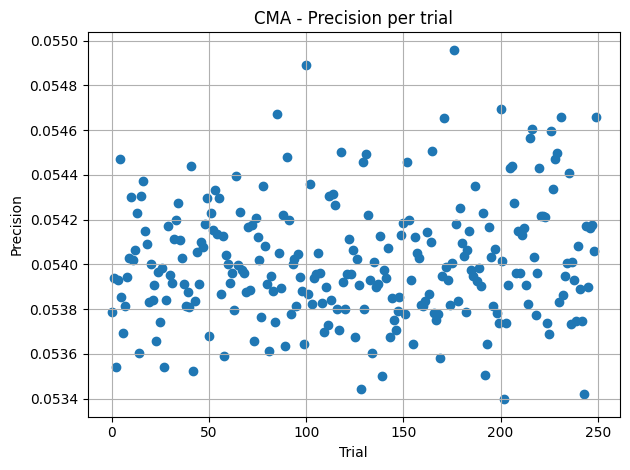

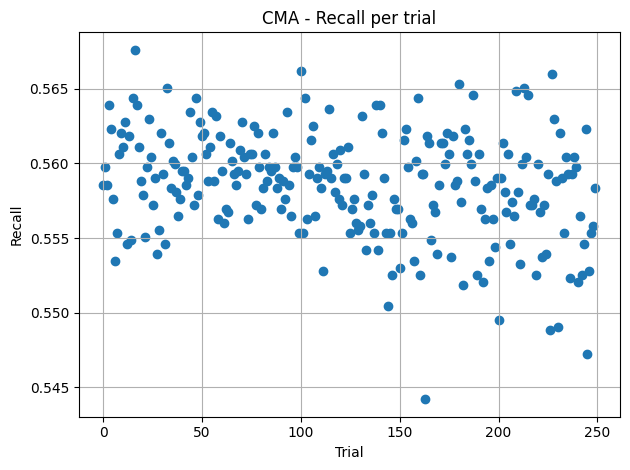

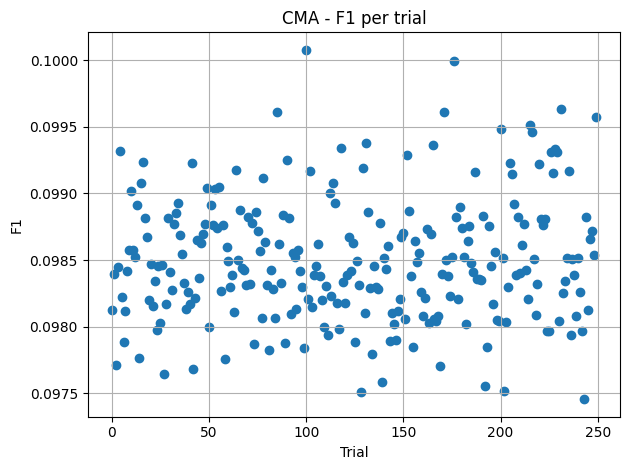

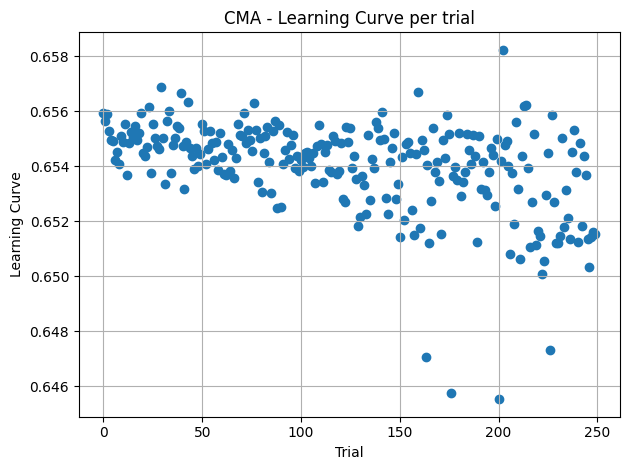

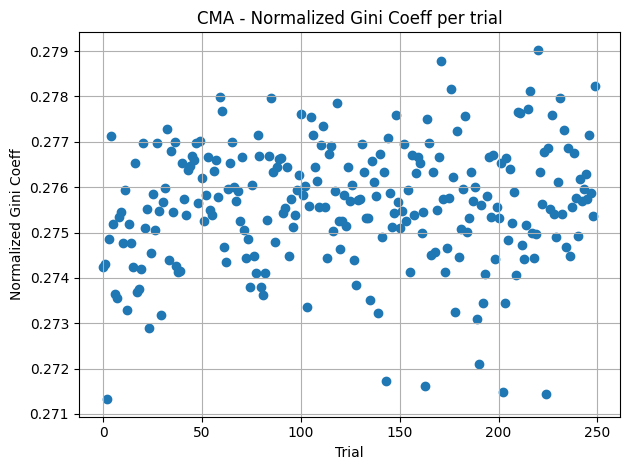

In [4]:
for metric_tuple in metrics_cma:
    metric_name, metric_vector = metric_tuple[0], metric_tuple[1]
    plt.figure()
    plt.scatter(time, metric_vector)
    plt.title(f'CMA - {metric_name} per trial')
    plt.ylabel(metric_name)
    plt.xlabel('Trial')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'plots/gbtree/CMA/{metric_name}_{current_time}.png')

In [5]:
cma_opt_hyp = pd.read_json('metrics/gbtree/CMA/best_params_2026-01-20 08:27:12.393529.json')

In [6]:
params = {
    "n_estimators": int(cma_opt_hyp['value'].values[0]),
    "max_depth": int(cma_opt_hyp['value'].values[1]),
    "eta": cma_opt_hyp['value'].values[2],
    "lambda": cma_opt_hyp['value'].values[3],
    "alpha": cma_opt_hyp['value'].values[4],
    "subsample": cma_opt_hyp['value'].values[5],
    "colsample_bytree": cma_opt_hyp['value'].values[6],
    "gamma": cma_opt_hyp['value'].values[7],
    "min_child_weight": int(cma_opt_hyp['value'].values[8])
    }

scale_pos_weight = (sum(y_train == 0) / sum(y_train == 1))
threshold = 0.5

xgb = XGBClassifier(objective = 'binary:logistic',
                    random_state = 0,
                    tree_method = 'hist',
                    booster = 'gbtree',
                    scale_pos_weight = scale_pos_weight,
                    **params)

xgb.fit(X_train, y_train)

y_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

In [ ]:
sample_submission = pd.read_csv('datasets/sample_submission.csv')

sample_submission['target'] = y_proba
sample_submission.to_csv('tests/sample_submission_CMA.csv', index = False)